In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
from sklearn import linear_model, model_selection, metrics, datasets
import statsmodels.api as sm
import seaborn as sns

In [2]:
data = pd.read_csv('C:/Users/Thu/Desktop/AML/Assignment1/pek-sha.csv')

In [3]:
data.head()

,ID,flightNumber,craftTypeCode,depAirport,traAirport,arrAirport,departureDate,arrivalDate,cabinClass,priceClass,price,rate,createDate,dateDifference
0,14393,HO1252,320,PEK,NaN,SHA,2019-01-04 06:35:00,2019-01-04 08:55:00,C,C,1860,1.00,2019-01-03 14:26:15,1
1,14409,MU5138,33L,PEK,NaN,SHA,2019-01-04 07:00:00,2019-01-04 09:15:00,C,I,1640,0.31,2019-01-03 14:26:15,1
2,14415,MU5138,33L,PEK,NaN,SHA,2019-01-04 07:00:00,2019-01-04 09:15:00,C,J,5360,1.00,2019-01-03 14:26:15,1
3,14429,HU7605,350,PEK,NaN,SHA,2019-01-04 07:20:00,2019-01-04 09:35:00,C,I,1635,0.29,2019-01-03 14:26:15,1
4,14431,HU7605,350,PEK,NaN,SHA,2019-01-04 07:20:00,2019-01-04 09:35:00,C,I,1640,0.29,2019-01-03 14:26:15,1


In [4]:
data.describe()

,ID,price,rate,dateDifference
count,3.003360e+05,300336.000000,300336.000000,300336.000000
mean,3.785370e+07,2209.684696,0.764667,6.682762
std,2.320571e+07,1755.003424,0.251366,7.501340
min,1.438400e+04,235.000000,0.000000,1.000000
25%,1.770736e+07,1005.000000,0.530000,2.000000
50%,3.718240e+07,1490.000000,0.860000,5.000000
75%,5.705183e+07,2980.000000,1.000000,7.000000
max,8.016500e+07,6410.000000,1.000000,30.000000


# 1) Data Exploration

#### (1) What is the minimum time interval between createDate and departureDate for valid records? Does it make sense?

dateDifference is the date difference between the create data and the actual departure date. So we find the min of dateDifference.

In [5]:
data['dateDifference'].min()

1

In [6]:
data.shape

(300336, 14)

The minium time interval between createDate and departureDate for valid records is 1 day. In real life cases, the date difference can be 0 day if the ticket is purchased on the same day of the departure day. This can happen in real life.

#### (2) Is the column price the original price or the discounted price?

In [7]:
data['cabinClass'].unique()

array(['C', 'F', 'Y'], dtype=object)

To answer this question, we need to see whether there is any significant correlation between price and rate. If there is significant correlation then price is the discounted price. There are 3 cabin classes (Y, C, F) with different price points so we examine the correlation seperately for each cabin class.

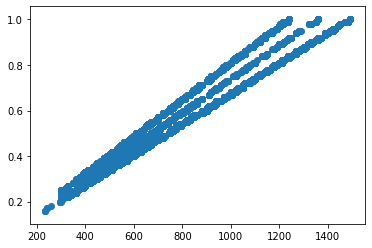

In [8]:
# Y cabin class:
data_Y = data[data['cabinClass']=='Y']
plt.scatter(data_Y['price'], data_Y['rate'])
plt.show()

In [9]:
data_Y[['price','rate']].corr()

,price,rate
price,1.000000,0.987816
rate,0.987816,1.000000


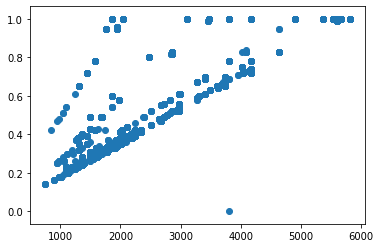

In [10]:
# C cabin class:
data_C = data[data['cabinClass']=='C']
plt.scatter(data_C['price'], data_C['rate'])
plt.show()

In [11]:
data_C[['price','rate']].corr()

,price,rate
price,1.000000,0.949287
rate,0.949287,1.000000


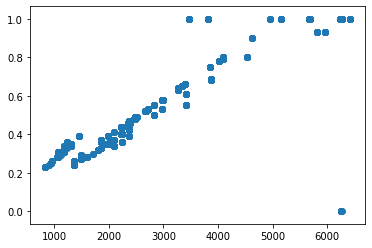

In [12]:
# F cabin class:
data_F = data[data['cabinClass']=='F']
plt.scatter(data_F['price'], data_F['rate'])
plt.show()

In [13]:
data_F[['price','rate']].corr()

,price,rate
price,1.000000,0.959987
rate,0.959987,1.000000


There is strong positive correlation between price and rate for each cabin class. Hence, we can conclude that the price is the discounted price.

#### (3) What are the original prices for each cabin class and each flight (a flight is identified by its flight number)? Tabulate flight number, departure time in hh:mm, cabin class and original price for each flight.

In [14]:
# Extracting departure time from departure date
data['time'] = data['departureDate'].apply(lambda x: x[10:16])

In [15]:
# Time is a string so we turn time to a numeric value (to be used in regression later on)
data['numeric_time'] = data['time'].apply(lambda x: int(x[:3]) + int(x[4:6])/60)

In [16]:
# Extracting airline from flight number
data['airline'] = data['flightNumber'].apply(lambda x: x[:2])

In [17]:
data.head()

,ID,flightNumber,craftTypeCode,depAirport,traAirport,arrAirport,departureDate,arrivalDate,cabinClass,priceClass,price,rate,createDate,dateDifference,time,numeric_time,airline
0,14393,HO1252,320,PEK,NaN,SHA,2019-01-04 06:35:00,2019-01-04 08:55:00,C,C,1860,1.00,2019-01-03 14:26:15,1,06:35,6.583333,HO
1,14409,MU5138,33L,PEK,NaN,SHA,2019-01-04 07:00:00,2019-01-04 09:15:00,C,I,1640,0.31,2019-01-03 14:26:15,1,07:00,7.000000,MU
2,14415,MU5138,33L,PEK,NaN,SHA,2019-01-04 07:00:00,2019-01-04 09:15:00,C,J,5360,1.00,2019-01-03 14:26:15,1,07:00,7.000000,MU
3,14429,HU7605,350,PEK,NaN,SHA,2019-01-04 07:20:00,2019-01-04 09:35:00,C,I,1635,0.29,2019-01-03 14:26:15,1,07:20,7.333333,HU
4,14431,HU7605,350,PEK,NaN,SHA,2019-01-04 07:20:00,2019-01-04 09:35:00,C,I,1640,0.29,2019-01-03 14:26:15,1,07:20,7.333333,HU


To answer question 3, we filter only the observations that rate is 1, which means the prices are original prices. <br/>
Assumptions: <br/>
1. All flights have at least one observation that rate is 1. <br/>
2. For flights that have several original prices, we take the average of the orginal prices as the original price of that flight.

In [18]:
data1 = data[data['rate']==1]

In [19]:
original_price = data1.groupby(['flightNumber','time','cabinClass'])['price'].mean()
print(original_price)

flightNumber  time    cabinClass
CA1501         08:30  C             5682.299652
                      F             5693.055556
                      Y             1490.000000
CA1515         15:30  C             5681.522956
                      F             5771.491803
                                       ...     
MU7032         10:00  F             6230.000000
                      Y             1490.000000
MU7106         14:05  C             5360.000000
                      F             5660.000000
                      Y             1490.000000
Name: price, Length: 231, dtype: float64


In [20]:
#to explain
original_price_ = data.groupby(['flightNumber','time','cabinClass'])['price'].mean()
print(original_price_)

flightNumber  time    cabinClass
CA1501         08:30  C             4096.145332
                      F             5126.777778
                      Y             1236.330853
CA1515         15:30  C             4299.556962
                      F             5217.538726
                                       ...     
MU7032         10:00  F             6230.000000
                      Y             1000.500000
MU7106         14:05  C             3479.166667
                      F             3276.666667
                      Y              906.734694
Name: price, Length: 231, dtype: float64


In [21]:
data1.head()

,ID,flightNumber,craftTypeCode,depAirport,traAirport,arrAirport,departureDate,arrivalDate,cabinClass,priceClass,price,rate,createDate,dateDifference,time,numeric_time,airline
0,14393,HO1252,320,PEK,NaN,SHA,2019-01-04 06:35:00,2019-01-04 08:55:00,C,C,1860,1.0,2019-01-03 14:26:15,1,06:35,6.583333,HO
2,14415,MU5138,33L,PEK,NaN,SHA,2019-01-04 07:00:00,2019-01-04 09:15:00,C,J,5360,1.0,2019-01-03 14:26:15,1,07:00,7.000000,MU
5,14433,HU7605,350,PEK,NaN,SHA,2019-01-04 07:20:00,2019-01-04 09:35:00,C,C,5660,1.0,2019-01-03 14:26:15,1,07:20,7.333333,HU
7,14451,CA1831,773,PEK,NaN,SHA,2019-01-04 07:30:00,2019-01-04 09:35:00,C,J,5530,1.0,2019-01-03 14:26:15,1,07:30,7.500000,CA
9,14491,MU5102,333,PEK,NaN,SHA,2019-01-04 08:00:00,2019-01-04 10:15:00,C,J,5360,1.0,2019-01-03 14:26:15,1,08:00,8.000000,MU


# 2) Linear Regression

#### (4) Are the original air ticket prices related to the departure time of the flights for each airline?

To know whether the original air ticket prices are related to departure time, we run a linear regression with price being target variable and departure time being explanatory variable.

In [22]:
regr = linear_model.LinearRegression()

In [23]:
data.shape, data1.shape

((300336, 17), (109807, 17))

In [24]:
x1 = data1[['numeric_time']]
y = data1['price']

In [25]:
regr.fit(x1,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [26]:
print('Coefficients:', regr.coef_)

Coefficients: [15.06803654]


In [27]:
print('Intercept:', regr.intercept_)

Intercept: 3200.903728197351


To see whether the coefficient of numeric_time is statistically significant, we need to see the p-value.

In [28]:
x2 = sm.add_constant(x1)

/Users/hoangtuanminhnguyen/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [29]:
x2

,const,numeric_time
0,1.0,6.583333
2,1.0,7.000000
5,1.0,7.333333
7,1.0,7.500000
9,1.0,8.000000
...,...,...
300312,1.0,21.083333
300317,1.0,21.250000
300323,1.0,21.500000
300329,1.0,21.833333


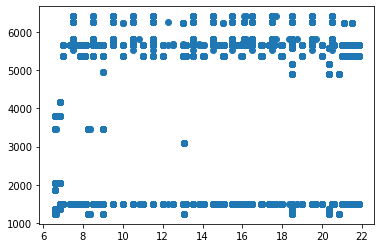

In [30]:
plt.scatter(x1,y)

In [31]:
est1 = sm.OLS(y,x2)

In [32]:
est2 = est1.fit()

In [33]:
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     125.6
Date:                Tue, 09 Jun 2020   Prob (F-statistic):           3.84e-29
Time:                        20:46:20   Log-Likelihood:            -9.9309e+05
No. Observations:              109807   AIC:                         1.986e+06
Df Residuals:                  109805   BIC:                         1.986e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3200.9037     20.046    159.674   

The coefficient is 15.068 and p-value is much smaller than the significance level of 5%. So we conclude that there is enough evidence that the original air price tickets are related to departure time.

#### (5) Are the discount rates related to how long in advance tickets are purchased?

To answer this question, we run linear regression with rate being target variable and dateDifference being explanatory variable for each cabin class.

In [34]:
# Run regression for class Y
x_Y = data_Y[['dateDifference']].values
y_Y = data_Y['rate'].values
regr.fit(x_Y,y_Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

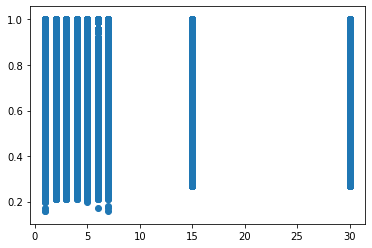

In [35]:
plt.scatter(x_Y,y_Y)

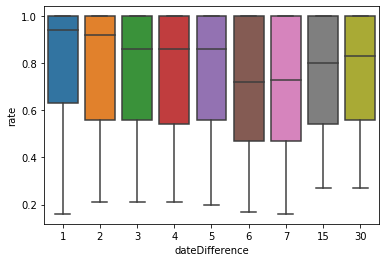

In [36]:
ax = sns.boxplot(x="dateDifference", y="rate", data=data_Y)

In [37]:
data_Y_7 = data_Y[data_Y['dateDifference']<=7]

In [38]:
x_Y_7 = data_Y_7[['dateDifference']].values
y_Y_7 = data_Y_7['rate'].values
regr.fit(x_Y_7,y_Y_7)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [39]:
print('Coefficients_Y_7:', regr.coef_)

Coefficients_Y_7: [-0.01345261]


In [40]:
print('Coefficients_Y:', regr.coef_)

Coefficients_Y: [-0.01345261]


In [41]:
print('Intercept_Y:', regr.intercept_)

Intercept_Y: 0.8230205925786385


In [42]:
#Run regression for class C
x_C = data_C[['dateDifference']].values
y_C = data_C['rate'].values
regr.fit(x_C,y_C)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [43]:
print('Coefficients_C:', regr.coef_)

Coefficients_C: [0.00066177]


In [44]:
print('Intercept_C:', regr.intercept_)

Intercept_C: 0.7228316568704538


In [45]:
#Run regression for class F
x_F = data_F[['dateDifference']].values
y_F = data_F['rate'].values
regr.fit(x_F,y_F)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [46]:
print('Coefficients_F:', regr.coef_)

Coefficients_F: [0.0003267]


In [47]:
print('Intercept_F:', regr.intercept_)

Intercept_F: 0.8191609953496972


The coefficients for dateDifference are very small for all 3 types of cabin class. Hence, we conclude that discount rates are not related to how long in advance tickets are purchased.

#### (6) Choose your own attributes to build two Lasso or ridge regression models, one for predicting rate and the other for predicting price. Are the performances of the two regression models significantly different? Why is it so?

In [48]:
# Get the day of departure from departureDate (Monday = 0, Sunday = 6)
data['Date'] = data['departureDate'].apply(lambda x: x[8:10])
data['Month'] = data['departureDate'].apply(lambda x: x[5:7])
data['Year'] = data['departureDate'].apply(lambda x: x[:4])
data['Day'] = data.apply(lambda r: date(int(r['Year']), int(r['Month']), int(r['Date'])).weekday(), axis=1)

In [49]:
data.head()

,ID,flightNumber,craftTypeCode,depAirport,traAirport,arrAirport,departureDate,arrivalDate,cabinClass,priceClass,...,rate,createDate,dateDifference,time,numeric_time,airline,Date,Month,Year,Day
0,14393,HO1252,320,PEK,NaN,SHA,2019-01-04 06:35:00,2019-01-04 08:55:00,C,C,...,1.00,2019-01-03 14:26:15,1,06:35,6.583333,HO,04,01,2019,4
1,14409,MU5138,33L,PEK,NaN,SHA,2019-01-04 07:00:00,2019-01-04 09:15:00,C,I,...,0.31,2019-01-03 14:26:15,1,07:00,7.000000,MU,04,01,2019,4
2,14415,MU5138,33L,PEK,NaN,SHA,2019-01-04 07:00:00,2019-01-04 09:15:00,C,J,...,1.00,2019-01-03 14:26:15,1,07:00,7.000000,MU,04,01,2019,4
3,14429,HU7605,350,PEK,NaN,SHA,2019-01-04 07:20:00,2019-01-04 09:35:00,C,I,...,0.29,2019-01-03 14:26:15,1,07:20,7.333333,HU,04,01,2019,4
4,14431,HU7605,350,PEK,NaN,SHA,2019-01-04 07:20:00,2019-01-04 09:35:00,C,I,...,0.29,2019-01-03 14:26:15,1,07:20,7.333333,HU,04,01,2019,4


In [50]:
# From Day, we derive whether the departureDate is on weekend or weekday
data['weekend'] = data['Day'].apply(lambda x: 1 if x>=5 else 0)

In [51]:
# Running regression with the numeric_time may not be the best since time is more categorical rather than ordinal. 
# Hence, we divide numeric_time to peak hours (12pm to 5pm) and non-peak hours (5pm to 12pm).
data['peak'] = data['numeric_time'].apply(lambda x: 1 if (x>=12 and x<=17) else 0)

In [52]:
data.head()

,ID,flightNumber,craftTypeCode,depAirport,traAirport,arrAirport,departureDate,arrivalDate,cabinClass,priceClass,...,dateDifference,time,numeric_time,airline,Date,Month,Year,Day,weekend,peak
0,14393,HO1252,320,PEK,NaN,SHA,2019-01-04 06:35:00,2019-01-04 08:55:00,C,C,...,1,06:35,6.583333,HO,04,01,2019,4,0,0
1,14409,MU5138,33L,PEK,NaN,SHA,2019-01-04 07:00:00,2019-01-04 09:15:00,C,I,...,1,07:00,7.000000,MU,04,01,2019,4,0,0
2,14415,MU5138,33L,PEK,NaN,SHA,2019-01-04 07:00:00,2019-01-04 09:15:00,C,J,...,1,07:00,7.000000,MU,04,01,2019,4,0,0
3,14429,HU7605,350,PEK,NaN,SHA,2019-01-04 07:20:00,2019-01-04 09:35:00,C,I,...,1,07:20,7.333333,HU,04,01,2019,4,0,0
4,14431,HU7605,350,PEK,NaN,SHA,2019-01-04 07:20:00,2019-01-04 09:35:00,C,I,...,1,07:20,7.333333,HU,04,01,2019,4,0,0


In [53]:
data['hour'] = data['numeric_time'].apply(lambda x: str(int(x)))

In [54]:
data.columns

Index(['ID', 'flightNumber', 'craftTypeCode', 'depAirport', 'traAirport',
       'arrAirport', 'departureDate', 'arrivalDate', 'cabinClass',
       'priceClass', 'price', 'rate', 'createDate', 'dateDifference', 'time',
       'numeric_time', 'airline', 'Date', 'Month', 'Year', 'Day', 'weekend',
       'peak', 'hour'],
      dtype='object')

In [55]:
# Perform one-hot encoding for cabinClass and airline
df = pd.get_dummies(data[['price', 'rate','weekend',
       'peak','dateDifference','cabinClass','airline','Day','Month','hour']])

In [56]:
df.head()

,price,rate,weekend,peak,dateDifference,Day,cabinClass_C,cabinClass_F,cabinClass_Y,airline_CA,...,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_6,hour_7,hour_8,hour_9
0,1860,1.00,0,0,1,4,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1640,0.31,0,0,1,4,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,5360,1.00,0,0,1,4,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1635,0.29,0,0,1,4,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1640,0.29,0,0,1,4,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [57]:
df.columns

Index(['price', 'rate', 'weekend', 'peak', 'dateDifference', 'Day',
       'cabinClass_C', 'cabinClass_F', 'cabinClass_Y', 'airline_CA',
       'airline_CZ', 'airline_FM', 'airline_HO', 'airline_HU', 'airline_MF',
       'airline_MU', 'Month_01', 'Month_02', 'Month_03', 'Month_04',
       'Month_05', 'Month_06', 'Month_07', 'Month_08', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_6', 'hour_7',
       'hour_8', 'hour_9'],
      dtype='object')

#### Model 1: Predicting price

##### Lasso

In [58]:
x2 = df[['weekend', 'peak', 'dateDifference', 'Day',
       'cabinClass_C', 'cabinClass_F', 'cabinClass_Y', 'airline_CA',
       'airline_CZ', 'airline_FM', 'airline_HO', 'airline_HU', 'airline_MF',
       'airline_MU', 'Month_01', 'Month_02', 'Month_03', 'Month_04',
       'Month_05', 'Month_06', 'Month_07', 'Month_08', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_6', 'hour_7',
       'hour_8', 'hour_9']]
y2 = df['price']

In [59]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x2, y2, test_size=0.2, random_state = 100)

In [60]:
for alpha in [1, 0.1, 0.01, 0.001]:
    lasso = linear_model.Lasso(alpha = alpha)
    lasso.fit(x_train, y_train)
    print('score', lasso.score(x_test, y_test))
    print(lasso.coef_)

score 0.7202313905188418
[-4.84219299e+02  1.08802421e+02 -2.29667540e+00  6.77459484e+01
  0.00000000e+00  7.01662235e+02 -2.74694475e+03  4.01288772e+02
 -2.25923117e+02  0.00000000e+00 -5.77782695e+02  1.38601074e+02
 -3.10874493e+02  1.50255261e+02  0.00000000e+00 -1.47829385e+02
 -1.76222814e+01  1.62101231e+02  5.14988499e+01 -0.00000000e+00
 -2.51612643e+00  0.00000000e+00  0.00000000e+00  9.59321354e+00
 -4.07311182e+01 -3.66724173e+01  2.86697441e+01  3.04219808e+01
  0.00000000e+00  6.40944468e+01  7.40685607e+01  8.12065572e+01
 -0.00000000e+00 -9.48190729e+01 -0.00000000e+00 -2.01862208e+02
 -1.28889282e+02 -2.72914227e+00]
score 0.7203885286161718
[-4.99475842e+02  1.19692444e+02 -2.55465781e+00  7.06716866e+01
  1.99259328e+03  2.70527259e+03 -7.54411020e+02  4.10643775e+02
 -2.45697058e+02 -0.00000000e+00 -5.99838416e+02  1.64693636e+02
 -3.99137678e+02  1.65526837e+02  4.43815598e-02 -1.56331916e+02
 -2.55671919e+01  1.75110601e+02  6.24712700e+01 -1.25565174e+00
 -9.41

/Users/hoangtuanminhnguyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15674153583.448792, tolerance: 74034249.34994143
  positive)


score 0.7203912758355635
[-5.00935559e+02  1.39173137e+02 -2.60745980e+00  7.09490285e+01
  2.34300059e+03  3.05635941e+03 -4.04129871e+02  3.21735713e+02
 -3.37776037e+02 -9.04535753e+01 -6.92252071e+02  7.77044860e+01
 -4.97857595e+02  7.67434652e+01  1.46316164e-02 -1.57228131e+02
 -2.63938335e+01  1.76070669e+02  6.31035548e+01 -2.44056461e+00
 -1.05026965e+01  2.97608683e+01  5.35797619e+00  1.86565865e+01
 -1.14463878e+02 -7.18822288e+01  1.34703516e+01  1.05944197e+01
 -2.09761859e+01  6.81758597e+01  9.79024903e+01  9.97777664e+01
  7.16719013e-01 -1.13463139e+02  0.00000000e+00 -2.22919581e+02
 -1.41929076e+02 -1.34247210e+01]
score 0.7203928027390929
[-5.01091331e+02  1.42199119e+02 -2.61578074e+00  7.09745610e+01
  2.37803603e+03  3.09146413e+03 -3.69101288e+02  3.01452199e+02
 -3.58632896e+02 -1.11262498e+02 -9.63337476e+02  5.76363266e+01
 -5.19115459e+02  5.64339471e+01  0.00000000e+00 -1.57327964e+02
 -2.65110379e+01  1.76147540e+02  6.31332608e+01 -2.58897364e+00
 -1.06

/Users/hoangtuanminhnguyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66370152910.293304, tolerance: 74034249.34994143
  positive)


In [61]:
y_pred = lasso.predict(x_test)

In [62]:
print(metrics.explained_variance_score(y_test, y_pred))
print(metrics.mean_absolute_error(y_test, y_pred))
print(metrics.mean_squared_error(y_test, y_pred, squared=False))

0.7203942576935205
655.5003264106515


TypeError: mean_squared_error() got an unexpected keyword argument 'squared'

##### Ridge

In [ ]:
for alpha in [1, 0.1, 0.01, 0.001]:
    ridge = linear_model.Ridge(alpha = alpha)
    ridge.fit(x_train, y_train)
    print('score:', ridge.score(x_test, y_test))
    print(ridge.coef_)

In [ ]:
y_pred1 = ridge.predict(x_test)

In [ ]:
print(metrics.explained_variance_score(y_test, y_pred1))
print(metrics.mean_absolute_error(y_test, y_pred1))
print(metrics.mean_squared_error(y_test, y_pred1, squared=False))

#### Model 2: Predicting rate

In [ ]:
x3 = df[['weekend', 'peak', 'dateDifference', 'Day',
       'cabinClass_C', 'cabinClass_F', 'cabinClass_Y', 'airline_CA',
       'airline_CZ', 'airline_FM', 'airline_HO', 'airline_HU', 'airline_MF',
       'airline_MU', 'Month_01', 'Month_02', 'Month_03', 'Month_04',
       'Month_05', 'Month_06', 'Month_07', 'Month_08', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_6', 'hour_7',
       'hour_8', 'hour_9']]
y3 = df['rate']

In [ ]:
x_train_r, x_test_r, y_train_r, y_test_r = model_selection.train_test_split(x3, y3, test_size=0.2, random_state = 100)

In [ ]:
for alpha in [1, 0.1, 0.01, 0.001]:
    lasso = linear_model.Lasso(alpha = alpha)
    lasso.fit(x_train_r, y_train_r)
    print('score', lasso.score(x_test_r, y_test_r))
    print(lasso.coef_)

In [ ]:
y_pred_r = lasso.predict(x_test_r)

In [ ]:
print(metrics.explained_variance_score(y_test_r, y_pred_r))
print(metrics.mean_absolute_error(y_test_r, y_pred_r))
print(metrics.mean_squared_error(y_test_r, y_pred_r, squared=False))

In [ ]:
df['rate'].hist()

In [ ]:
df['price'].hist()

The price prediction result is much better than the rate prediction result because the rate distribution is very skewed.

# 3) Logistic Regression

#### (7) Choose your own attributes to build a binary classifier on if there is any discount on the purchase price: class 0 for no discount, class 1 for price being discounted. Identify 2 to 5 important factors that determine if there is discount.

In [63]:
# Derive target variable Discount (1 if there is discount, 0 if there is no discount) from rate
df['Discount'] = df['rate'].apply(lambda x: 1 if x <1 else 0)

In [64]:
df.head()

,price,rate,weekend,peak,dateDifference,Day,cabinClass_C,cabinClass_F,cabinClass_Y,airline_CA,...,hour_17,hour_18,hour_19,hour_20,hour_21,hour_6,hour_7,hour_8,hour_9,Discount
0,1860,1.00,0,0,1,4,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1640,0.31,0,0,1,4,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,5360,1.00,0,0,1,4,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1635,0.29,0,0,1,4,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,1640,0.29,0,0,1,4,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [65]:
df.columns

Index(['price', 'rate', 'weekend', 'peak', 'dateDifference', 'Day',
       'cabinClass_C', 'cabinClass_F', 'cabinClass_Y', 'airline_CA',
       'airline_CZ', 'airline_FM', 'airline_HO', 'airline_HU', 'airline_MF',
       'airline_MU', 'Month_01', 'Month_02', 'Month_03', 'Month_04',
       'Month_05', 'Month_06', 'Month_07', 'Month_08', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'Discount'],
      dtype='object')

In [66]:
x4 = df[['weekend', 'peak', 'dateDifference', 'Day',
       'cabinClass_C', 'cabinClass_F', 'cabinClass_Y', 'airline_CA',
       'airline_CZ', 'airline_FM', 'airline_HO', 'airline_HU', 'airline_MF',
       'airline_MU', 'Month_01', 'Month_02', 'Month_03', 'Month_04',
       'Month_05', 'Month_06', 'Month_07', 'Month_08', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_6', 'hour_7',
       'hour_8', 'hour_9']]
y4 = df['Discount']

In [67]:
x_train_4, x_test_4, y_train_4, y_test_4 = model_selection.train_test_split(x4, y4, test_size = 0.2, random_state = 610)

In [68]:
estimator = linear_model.LogisticRegression()

In [69]:
estimator.fit(x_train_4, y_train_4)

/Users/hoangtuanminhnguyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [70]:
y_pred_4 = estimator.predict(x_test_4)
print('confusion matrix:', metrics.confusion_matrix(y_test_4, y_pred_4))
print('accuracy:', metrics.accuracy_score(y_test_4, y_pred_4))
print('precision:', metrics.precision_score(y_test_4, y_pred_4))
print('recall:', metrics.recall_score(y_test_4, y_pred_4))

confusion matrix: [[ 5173 16782]
 [ 4918 33195]]
accuracy: 0.638742758207365
precision: 0.6642055345458912
recall: 0.8709626636580694


In [71]:
x_test_4

,weekend,peak,dateDifference,Day,cabinClass_C,cabinClass_F,cabinClass_Y,airline_CA,airline_CZ,airline_FM,...,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_6,hour_7,hour_8,hour_9
89857,0,0,3,4,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
259380,0,0,5,2,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
150644,0,1,2,2,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
37597,0,1,3,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
72306,0,1,7,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253865,1,1,5,5,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
200995,1,1,3,5,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
293210,0,1,7,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
244681,0,0,5,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [72]:
y_test_4

89857     1
259380    1
150644    0
37597     1
72306     0
         ..
253865    0
200995    1
293210    0
244681    1
189711    1
Name: Discount, Length: 60068, dtype: int64

In [76]:
x_test_4['y_pred_binary'] = y_pred_4

/Users/hoangtuanminhnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [77]:
x_test_4['y_test_binary'] = y_test_4

/Users/hoangtuanminhnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#### (8) Let us now create three classes for all records with rate < 1: class 1 for 0.75 < rate < 1, class 2 for 0.5 < rate ≤ 0.75 and class 3 for rate ≤ 0.5 Choose your own attributes to build an ovr multi-class logistic regression classifier for this purpose. Plot the 5 ROC curves in one plot, 3 for each class, 1 for micro-average and another for macro-average, and report the respective AUC under each of the ROC curves.

In [78]:
df1 = df[df['rate'] <1]

In [79]:
df1['rate class'] = df1['rate'].apply(lambda x: 1 if x>0.75 else (2 if x>0.5 else 3))

/Users/hoangtuanminhnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [80]:
df1.head()

,price,rate,weekend,peak,dateDifference,Day,cabinClass_C,cabinClass_F,cabinClass_Y,airline_CA,...,hour_18,hour_19,hour_20,hour_21,hour_6,hour_7,hour_8,hour_9,Discount,rate class
1,1640,0.31,0,0,1,4,1,0,0,0,...,0,0,0,0,0,1,0,0,1,3
3,1635,0.29,0,0,1,4,1,0,0,0,...,0,0,0,0,0,1,0,0,1,3
4,1640,0.29,0,0,1,4,1,0,0,0,...,0,0,0,0,0,1,0,0,1,3
6,1860,0.34,0,0,1,4,1,0,0,1,...,0,0,0,0,0,1,0,0,1,3
8,1800,0.34,0,0,1,4,1,0,0,0,...,0,0,0,0,0,0,1,0,1,3


In [81]:
df1.columns

Index(['price', 'rate', 'weekend', 'peak', 'dateDifference', 'Day',
       'cabinClass_C', 'cabinClass_F', 'cabinClass_Y', 'airline_CA',
       'airline_CZ', 'airline_FM', 'airline_HO', 'airline_HU', 'airline_MF',
       'airline_MU', 'Month_01', 'Month_02', 'Month_03', 'Month_04',
       'Month_05', 'Month_06', 'Month_07', 'Month_08', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'Discount', 'rate class'],
      dtype='object')

In [82]:
x5 = df1[['weekend', 'peak', 'dateDifference',
       'cabinClass_C', 'cabinClass_F', 'cabinClass_Y', 'airline_CA',
       'airline_CZ', 'airline_FM', 'airline_HO', 'airline_HU', 'airline_MF',
       'airline_MU']]
y5 = df1['rate class']

In [83]:
x5_train, x5_test, y5_train, y5_test = model_selection.train_test_split(x5,y5, test_size = 0.2, random_state=100)

In [84]:
# One vs all
ovr_estimator = linear_model.LogisticRegression(solver = 'lbfgs',
    multi_class = 'ovr')
ovr_estimator.fit(x5_train,y5_train)
ovr_predict = ovr_estimator.predict(x5_test)

ovr_report = """
The evaluation report of OVR is:
Confusion Matrix:
{}
Accuracy: {}
""".format(metrics.confusion_matrix(y5_test, ovr_predict),
           metrics.accuracy_score(y5_test, ovr_predict))
print(ovr_report)
print('The classification report of OVR:\n {}'
      .format(metrics.classification_report(y5_test, ovr_predict)))



The evaluation report of OVR is:
Confusion Matrix:
[[9781  979 1840]
 [4236 3648 3824]
 [3945 1555 8298]]
Accuracy: 0.5701726762189682

The classification report of OVR:
               precision    recall  f1-score   support

           1       0.54      0.78      0.64     12600
           2       0.59      0.31      0.41     11708
           3       0.59      0.60      0.60     13798

    accuracy                           0.57     38106
   macro avg       0.58      0.56      0.55     38106
weighted avg       0.58      0.57      0.55     38106



In [85]:
#Softmax
sm_estimator = linear_model.LogisticRegression(
    solver = 'lbfgs',
    multi_class = 'multinomial',
    max_iter = 1000)
sm_estimator.fit(x5_train, y5_train)

sm_predict = sm_estimator.predict(x5_test)

sm_report = """
The evaluation report of Softmax is:
Confusion Matrix:
{}
Accuracy: {}
""".format(metrics.confusion_matrix(y5_test, sm_predict),
           metrics.accuracy_score(y5_test, sm_predict))
print(sm_report)
print('The classification report of Softmax:\n {}'
      .format(metrics.classification_report(y5_test, sm_predict)))


The evaluation report of Softmax is:
Confusion Matrix:
[[9576 1187 1837]
 [4106 3793 3809]
 [3882 1634 8282]]
Accuracy: 0.5681782396472996

The classification report of Softmax:
               precision    recall  f1-score   support

           1       0.55      0.76      0.63     12600
           2       0.57      0.32      0.41     11708
           3       0.59      0.60      0.60     13798

    accuracy                           0.57     38106
   macro avg       0.57      0.56      0.55     38106
weighted avg       0.57      0.57      0.55     38106



Hence, we choose Logistic Regression to continue

In [138]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score
from itertools import cycle

y_score = ovr_estimator.predict_proba(x5_test)
y_test = pd.get_dummies(y5_test).values

In [139]:
# Compute ROC curve and ROC area for each class
n_classes=3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

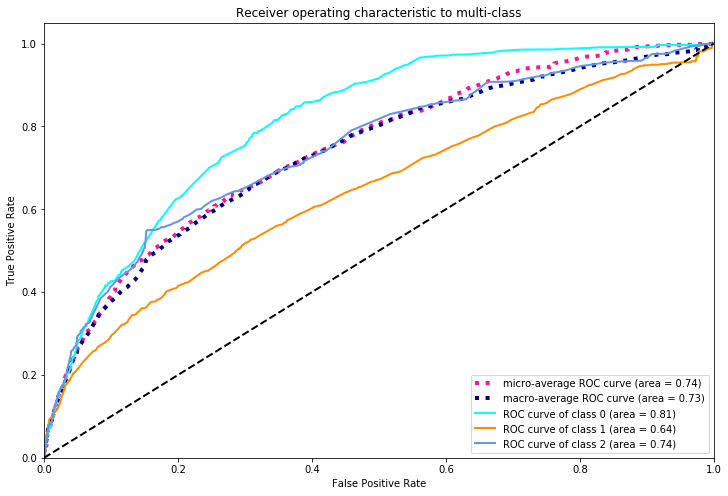

In [143]:
import numpy as np

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw = 2
plt.figure(figsize=(12, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

## (9)

#### Retraining multi-class logistic regression

When using model stacking, we need to make sure the multi-class model is not trained on data samples that later it is used to predict on. Because the train_test_split function in Q8 generates a different split compared to Q7, we can't use the model in Q8. Instead, we are going to re-train the multi-class model with training split consistent with Q7.

In [87]:
df['rate_class'] = df['rate'].apply(lambda x: 0 if x==1 else( 1 if (x>0.75) else (2 if x>0.5 else 3)))

In [88]:
ind = x_train_4.index
x_train_4['rate_class'] = df['rate_class'].loc[ind]

/Users/hoangtuanminhnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [89]:
x_train_4.rate_class.value_counts()

0    87852
3    54937
1    50653
2    46826
Name: rate_class, dtype: int64

In [90]:
train = x_train_4[x_train_4.rate_class > 0]
x_train_5 = train[['weekend', 'peak', 'dateDifference',
    'cabinClass_C', 'cabinClass_F', 'cabinClass_Y', 'airline_CA',
    'airline_CZ', 'airline_FM', 'airline_HO', 'airline_HU', 'airline_MF',
    'airline_MU']]
y_train_5 = train['rate_class']

In [91]:
ovr_estimator = linear_model.LogisticRegression(solver = 'lbfgs',
    multi_class = 'ovr')
ovr_estimator.fit(x_train_5,y_train_5)

/Users/hoangtuanminhnguyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#### Stack two models

In [92]:
ind = x_test_4.index
x_test_4['rate_class'] = df['rate_class'].loc[ind]

/Users/hoangtuanminhnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [93]:
x_test_4['rate_class'].value_counts()

0    21955
3    13702
1    12688
2    11723
Name: rate_class, dtype: int64

In [94]:
x_test_5 = x_test_4[x_test_4.y_pred_binary == 1]
x_test_5 = x_test_5[['weekend', 'peak', 'dateDifference',
       'cabinClass_C', 'cabinClass_F', 'cabinClass_Y', 'airline_CA',
       'airline_CZ', 'airline_FM', 'airline_HO', 'airline_HU', 'airline_MF',
       'airline_MU']]

In [95]:
y_pred_5 = ovr_estimator.predict(x_test_5)

In [103]:
x_test_4['y_pred_class'] = 0
x_test_4['y_pred_class'].loc[x_test_5.index] = y_pred_5

/Users/hoangtuanminhnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/hoangtuanminhnguyen/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/hoangtuanminhnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

In [104]:
x_test_4.columns

Index(['weekend', 'peak', 'dateDifference', 'Day', 'cabinClass_C',
       'cabinClass_F', 'cabinClass_Y', 'airline_CA', 'airline_CZ',
       'airline_FM', 'airline_HO', 'airline_HU', 'airline_MF', 'airline_MU',
       'Month_01', 'Month_02', 'Month_03', 'Month_04', 'Month_05', 'Month_06',
       'Month_07', 'Month_08', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'y_pred_binary', 'y_test_binary', 'rate_class', 'y_pred_class'],
      dtype='object')

In [105]:
x_test_4.y_pred_class.value_counts()

1    25070
3    19566
0    10091
2     5341
Name: y_pred_class, dtype: int64

In [107]:
x_test_4.rate_class.value_counts()

0    21955
3    13702
1    12688
2    11723
Name: rate_class, dtype: int64

In [108]:
stack_report = """
    The evaluation report of OVR is:
    Confusion Matrix:
    {}
    Accuracy: {}
    """.format(metrics.confusion_matrix(x_test_4.rate_class, x_test_4.y_pred_class),
               metrics.accuracy_score(x_test_4.rate_class, x_test_4.y_pred_class))
print(stack_report)
print('The classification report of OVR:\n {}'
      .format(metrics.classification_report(x_test_4.rate_class, x_test_4.y_pred_class)))


    The evaluation report of OVR is:
    Confusion Matrix:
    [[5173 8182 1494 7106]
 [1475 8765  848 1600]
 [2140 4206 2003 3374]
 [1303 3917  996 7486]]
    Accuracy: 0.3900079909435973
    
The classification report of OVR:
               precision    recall  f1-score   support

           0       0.51      0.24      0.32     21955
           1       0.35      0.69      0.46     12688
           2       0.38      0.17      0.23     11723
           3       0.38      0.55      0.45     13702

    accuracy                           0.39     60068
   macro avg       0.40      0.41      0.37     60068
weighted avg       0.42      0.39      0.36     60068



Seems like the stacking model does not perform well because the error of the binary model is further propagated into the multi-class model.